## Environment Setup

In [1]:

!pip install -q kaggle librosa soundfile joblib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import joblib
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout,
    Bidirectional, Masking
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)


## Kaggle Dataset Loading

In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d ejlok1/cremad
!unzip -q cremad.zip

DATA_PATH = "/content/AudioWAV"

Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 93% 420M/451M [00:00<00:00, 447MB/s]
100% 451M/451M [00:01<00:00, 453MB/s]


In [4]:
print("Total files:", len(os.listdir(DATA_PATH)))


Total files: 7442


## Label Parsing & Emotion Filtering

In [5]:
emotion_map = {
    "ANG": 0,
    "HAP": 1,
    "SAD": 2,
    "DIS": 3
}

file_paths = []
labels = []

for file in os.listdir(DATA_PATH):
    emotion_code = file.split("_")[2]

    if emotion_code in emotion_map:
        file_paths.append(os.path.join(DATA_PATH, file))
        labels.append(emotion_map[emotion_code])

print("Filtered samples:", len(file_paths))


Filtered samples: 5084


## Feature Extraction Pipeline

In [6]:
SAMPLE_RATE = 16000
N_MFCC = 40
MAX_FRAMES = 400

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Trim silence
    y, _ = librosa.effects.trim(y)

    # MFCC
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr,
        n_mfcc=N_MFCC,
        n_fft=400,
        hop_length=160
    )

    # Delta
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.vstack([mfcc, delta, delta2])
    features = features.T  # (T, 120)

    return features


## Build Dataset

In [7]:
# ============================================================
# 6. DATASET BUILDING
# ============================================================

def pad_or_truncate(features):
    if features.shape[0] > MAX_FRAMES:
        return features[:MAX_FRAMES]
    else:
        pad_width = MAX_FRAMES - features.shape[0]
        return np.pad(features, ((0, pad_width), (0, 0)), mode='constant')

X = []
y = []

for path, label in zip(file_paths, labels):
    features = extract_features(path)
    features = pad_or_truncate(features)
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("Final shape:", X.shape)


Final shape: (5084, 400, 120)


## Standardization

In [9]:
scaler = StandardScaler()

X_reshaped = X.reshape(-1, X.shape[-1])
scaler.fit(X_reshaped)

X_scaled = scaler.transform(X_reshaped).reshape(X.shape)

joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

## Model Architecture

In [11]:
input_layer = Input(shape=(MAX_FRAMES, 120))

x = Masking(mask_value=0.0)(input_layer)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64))(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 120)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 400, 120)  │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 400, 120)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 400)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 400, 256)  │    254,976 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 400, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 427,844 (1.63 MB)

 Trainable params: 427,844 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [12]:
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4),
    ModelCheckpoint("best_ser_model.h5", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2693 - loss: 1.3976

128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.2693 - loss: 1.3976 - val_accuracy: 0.3854 - val_loss: 1.2865 - learning_rate: 0.0010
Epoch 2/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3967 - loss: 1.2455

128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.3971 - loss: 1.2448 - val_accuracy: 0.4907 - val_loss: 1.1206 - learning_rate: 0.0010
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.4820 - loss: 1.1239 - val_accuracy: 0.4956 - val_loss: 1.1234 - learning_rate: 0.0010
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5090 - loss: 1.0885

128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.5092 - loss: 1.0883 - val_accuracy: 0.5084 - val_loss: 1.0957 - learning_rate: 0.0010
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5702 - loss: 0.9861

128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.5702 - loss: 0.9860 - val_accuracy: 0.5054 - val_loss: 1.0870 - learning_rate: 0.0010
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.6025 - loss: 0.9323 - val_accuracy: 0.4877 - val_loss: 1.1984 - learning_rate: 0.0010
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6424 - loss: 0.8578 - val_accuracy: 0.4966 - val_loss: 1.1944 - learning_rate: 0.0010
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.7383 - loss: 0.6791 - val_accuracy: 0.4926 - val_loss: 1.2629 - learning_rate: 0.0010
Epoch 9/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7891 - loss: 0.5613 - val_accuracy: 0.5074 - val_loss: 1.3912 - learning_rate: 0.0010
Epoch 10/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8558 - loss: 0.4228 - val_accuracy: 0.5113 - val_loss: 1.5142 - learning_rate: 1.0000e-04
Epoch 11/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8918 - loss: 0.325

## Evaluation

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       254
           1       0.37      0.50      0.42       254
           2       0.57      0.66      0.62       255
           3       0.40      0.17      0.23       254

    accuracy                           0.51      1017
   macro avg       0.50      0.51      0.48      1017
weighted avg       0.50      0.51      0.48      1017



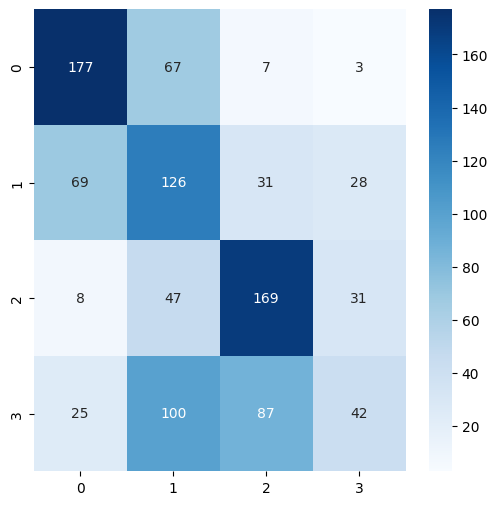

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## Save Model

In [33]:
model.save("final_ser_model.keras")


## Inference Test Cell

In [25]:
# ============================================================
# 12. INFERENCE TEST
# ============================================================

sample = X_test[3:4]
prediction = model.predict(sample)

class_map = {
    0: "Angry",
    1: "Happy",
    2: "Sad",
    3: "Disgust"
}

print("Predicted:", class_map[np.argmax(prediction)])
print("Confidence:", np.max(prediction))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted: Sad
Confidence: 0.554385


## Upload & Predict Emotion

In [31]:
model.save("final_ser_model_copy.keras")


In [32]:
# ============================================================
# UPLOAD AUDIO FILE AND PREDICT EMOTION
# ============================================================

from google.colab import files
import numpy as np
import librosa
import joblib
import tensorflow as tf

# -----------------------------
# 1. Upload MP3 or WAV file
# -----------------------------
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)

# -----------------------------
# 2. Load model and scaler
# -----------------------------
model = tf.keras.models.load_model("final_ser_model_copy.keras")
scaler = joblib.load("scaler.pkl")

# -----------------------------
# 3. Feature Extraction (Same as Training)
# -----------------------------
SAMPLE_RATE = 16000
N_MFCC = 40
MAX_FRAMES = 400

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Trim silence
    y, _ = librosa.effects.trim(y)

    # Extract MFCC
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=400,
        hop_length=160
    )

    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.vstack([mfcc, delta, delta2])
    features = features.T  # (T, 120)

    return features

# -----------------------------
# 4. Pad or Truncate
# -----------------------------
def pad_or_truncate(features):
    if features.shape[0] > MAX_FRAMES:
        return features[:MAX_FRAMES]
    else:
        pad_width = MAX_FRAMES - features.shape[0]
        return np.pad(features, ((0, pad_width), (0, 0)), mode='constant')

features = extract_features(file_name)
features = pad_or_truncate(features)

# -----------------------------
# 5. Scale features
# -----------------------------
features_reshaped = features.reshape(-1, features.shape[-1])
features_scaled = scaler.transform(features_reshaped).reshape(1, MAX_FRAMES, 120)

# -----------------------------
# 6. Predict
# -----------------------------
prediction = model.predict(features_scaled)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

class_map = {
    0: "Angry",
    1: "Happy",
    2: "Sad",
    3: "Disgust"
}

print("\n🎭 Predicted Emotion:", class_map[predicted_class])
print("🔍 Confidence:", round(float(confidence), 4))


Saving angry.mp3 to angry (2).mp3
Uploaded file: angry (2).mp3


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step

🎭 Predicted Emotion: Angry
🔍 Confidence: 0.6212


In [34]:
# ============================================================
# UPLOAD AUDIO FILE AND PREDICT EMOTION
# ============================================================

from google.colab import files
import numpy as np
import librosa
import joblib
import tensorflow as tf

# -----------------------------
# 1. Upload MP3 or WAV file
# -----------------------------
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)

# -----------------------------
# 2. Load model and scaler
# -----------------------------
model = tf.keras.models.load_model("final_ser_model_copy.keras")
scaler = joblib.load("scaler.pkl")

# -----------------------------
# 3. Feature Extraction (Same as Training)
# -----------------------------
SAMPLE_RATE = 16000
N_MFCC = 40
MAX_FRAMES = 400

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Trim silence
    y, _ = librosa.effects.trim(y)

    # Extract MFCC
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=400,
        hop_length=160
    )

    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.vstack([mfcc, delta, delta2])
    features = features.T  # (T, 120)

    return features

# -----------------------------
# 4. Pad or Truncate
# -----------------------------
def pad_or_truncate(features):
    if features.shape[0] > MAX_FRAMES:
        return features[:MAX_FRAMES]
    else:
        pad_width = MAX_FRAMES - features.shape[0]
        return np.pad(features, ((0, pad_width), (0, 0)), mode='constant')

features = extract_features(file_name)
features = pad_or_truncate(features)

# -----------------------------
# 5. Scale features
# -----------------------------
features_reshaped = features.reshape(-1, features.shape[-1])
features_scaled = scaler.transform(features_reshaped).reshape(1, MAX_FRAMES, 120)

# -----------------------------
# 6. Predict
# -----------------------------
prediction = model.predict(features_scaled)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

class_map = {
    0: "Angry",
    1: "Happy",
    2: "Sad",
    3: "Disgust"
}

print("\n🎭 Predicted Emotion:", class_map[predicted_class])
print("🔍 Confidence:", round(float(confidence), 4))


Saving happy.mp3 to happy.mp3
Uploaded file: happy.mp3


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step

🎭 Predicted Emotion: Happy
🔍 Confidence: 0.7362
